数据集下载，或直接运行单元格2可以直接读取下载好的数据，防止网络问题下载失败或下载时间过长

In [31]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
  
# fetch dataset 
individual_household_electric_power_consumption = fetch_ucirepo(id=235) 
  
# data (as pandas dataframes) 
X = individual_household_electric_power_consumption.data.features 
y = individual_household_electric_power_consumption.data.targets 
  
# metadata 
print(individual_household_electric_power_consumption.metadata) 
  
# variable information 
print(individual_household_electric_power_consumption.variables) 

print(X.head())

# 合并日期和时间列
X['Datetime'] = pd.to_datetime(X['Date'] + ' ' + X['Time'])
# 设置索引
X.set_index('Datetime', inplace=True)

# 保存数据，保留索引
X.to_csv('individual_household_electric_power_consumption_features.csv', index=True)

{'uci_id': 235, 'name': 'Individual Household Electric Power Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/235/data.csv', 'abstract': 'Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.', 'area': 'Physics and Chemistry', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 2075259, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2006, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C58K54', 'creators': ['Georges Hebrail', 'Alice Berard'], 'intro_paper': None, 'additional_info': {'summary': 'This archiv

直接读取已经下载好转换为csv的数据，减少下载时间
对数据进行预处理，提取时间特征，填充缺失值等

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 读取数据，保留时间索引
X = pd.read_csv('individual_household_electric_power_consumption_features.csv', index_col=0, parse_dates=True)

# 选取global_active_power作为预测目标
X = X['Global_active_power'].replace('?', np.nan).astype(float) # 替换缺失值并转换为float类型
X = X.resample('H').mean()  # 按小时重采样并计算均值

# Handle missing values
X.fillna(method='ffill', inplace=True)      #向前填充
X.fillna(method='bfill', inplace=True)      #向后填充

scaler = MinMaxScaler()  # 创建归一化器
X = scaler.fit_transform(X.values.reshape(-1, 1)).flatten()  # 训练集归一化



/tmp/ipykernel_90095/735023100.py:6: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  X = pd.read_csv('individual_household_electric_power_consumption_features.csv', index_col=0, parse_dates=True)
/tmp/ipykernel_90095/735023100.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  X = pd.read_csv('individual_household_electric_power_consumption_features.csv', index_col=0, parse_dates=True)
/tmp/ipykernel_90095/735023100.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  X = X.resample('H').mean()  # 按小时重采样并计算均值
/tmp/ipykernel_90095/735023100.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='ffill', inplace=True)      #向前填充
/tmp/ipykernel_90095/73502

滑动窗口法构建时间序列数据集

将时间序列数据划分为输入序列和目标值，形成监督学习的数据

In [2]:
from torch.utils.data import Dataset
import torch

# 构建时序数据集，输入为前seq_len，输出为第seq_len+1
class SequenceDataset(Dataset):
    def __init__(self, data, seq_len=24):
        self.data = data  # 归一化后的一维数组
        self.seq_len = seq_len  # 序列长度（如24小时）

    def __len__(self):
        return len(self.data) - self.seq_len  # 可用样本数

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]  # 输入序列
        y = self.data[idx+self.seq_len]      # 目标值
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
# 将归一化后的数据分割为训练集和验证集
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
X_val = X[train_size:]
print(f"训练集大小: {len(X_train)}")
print(f"验证集大小: {len(X_val)}")

batch_size = 1024
# 创建训练和验证数据集
train_dataset = SequenceDataset(X_train, seq_len=24)        #前24小时预测第25小时
val_dataset = SequenceDataset(X_val, seq_len=24)        #前24小时预测第25小时

训练集大小: 27668
验证集大小: 6917


lstm模型定义与预测

使用设备: cuda
模型参数量: 339,585


Epoch 1/50 | Train Loss: 0.033065 | Val Loss: 0.014128 | LR: 0.001000


Epoch 2/50 | Train Loss: 0.016640 | Val Loss: 0.005987 | LR: 0.001000


Epoch 3/50 | Train Loss: 0.007625 | Val Loss: 0.002467 | LR: 0.001000


Epoch 4/50 | Train Loss: 0.004849 | Val Loss: 0.001563 | LR: 0.001000


Epoch 5/50 | Train Loss: 0.003637 | Val Loss: 0.001198 | LR: 0.001000


Epoch 6/50 | Train Loss: 0.003219 | Val Loss: 0.001084 | LR: 0.001000


Epoch 7/50 | Train Loss: 0.003005 | Val Loss: 0.001135 | LR: 0.001000


Epoch 8/50 | Train Loss: 0.002886 | Val Loss: 0.001026 | LR: 0.001000


Epoch 9/50 | Train Loss: 0.002706 | Val Loss: 0.000919 | LR: 0.001000


Epoch 10/50 | Train Loss: 0.002611 | Val Loss: 0.000847 | LR: 0.001000


Epoch 11/50 | Train Loss: 0.002493 | Val Loss: 0.000793 | LR: 0.001000


Epoch 12/50 | Train Loss: 0.002443 | Val Loss: 0.000778 | LR: 0.001000


Epoch 13/50 | Train Loss: 0.002351 | Val Loss: 0.000713 | LR: 0.001000


Epoch 14/50 | Train Loss: 0.002219 | Val Loss: 0.000684 | LR: 0.001000


Epoch 15/50 | Train Loss: 0.002160 | Val Loss: 0.000661 | LR: 0.001000


Epoch 16/50 | Train Loss: 0.002116 | Val Loss: 0.000636 | LR: 0.001000


Epoch 17/50 | Train Loss: 0.002057 | Val Loss: 0.000604 | LR: 0.001000


Epoch 18/50 | Train Loss: 0.001965 | Val Loss: 0.000578 | LR: 0.001000


Epoch 19/50 | Train Loss: 0.001944 | Val Loss: 0.000555 | LR: 0.001000


Epoch 20/50 | Train Loss: 0.001861 | Val Loss: 0.000538 | LR: 0.001000


Epoch 21/50 | Train Loss: 0.001837 | Val Loss: 0.000533 | LR: 0.001000


Epoch 22/50 | Train Loss: 0.001779 | Val Loss: 0.000519 | LR: 0.001000


Epoch 23/50 | Train Loss: 0.001753 | Val Loss: 0.000484 | LR: 0.001000


Epoch 24/50 | Train Loss: 0.001707 | Val Loss: 0.000486 | LR: 0.001000


Epoch 25/50 | Train Loss: 0.001670 | Val Loss: 0.000474 | LR: 0.001000


Epoch 26/50 | Train Loss: 0.001597 | Val Loss: 0.000449 | LR: 0.001000


Epoch 27/50 | Train Loss: 0.001605 | Val Loss: 0.000448 | LR: 0.001000


Epoch 28/50 | Train Loss: 0.001591 | Val Loss: 0.000437 | LR: 0.001000


Epoch 29/50 | Train Loss: 0.001550 | Val Loss: 0.000425 | LR: 0.001000


Epoch 30/50 | Train Loss: 0.001468 | Val Loss: 0.000422 | LR: 0.001000


Epoch 31/50 | Train Loss: 0.001453 | Val Loss: 0.000428 | LR: 0.001000


Epoch 32/50 | Train Loss: 0.001493 | Val Loss: 0.000411 | LR: 0.001000


Epoch 33/50 | Train Loss: 0.001441 | Val Loss: 0.000423 | LR: 0.001000


Epoch 34/50 | Train Loss: 0.001394 | Val Loss: 0.000432 | LR: 0.001000


Epoch 35/50 | Train Loss: 0.001400 | Val Loss: 0.000414 | LR: 0.001000


Epoch 36/50 | Train Loss: 0.001378 | Val Loss: 0.000404 | LR: 0.001000


Epoch 37/50 | Train Loss: 0.001358 | Val Loss: 0.000402 | LR: 0.001000


Epoch 38/50 | Train Loss: 0.001366 | Val Loss: 0.000423 | LR: 0.001000


Epoch 39/50 | Train Loss: 0.001327 | Val Loss: 0.000405 | LR: 0.001000


Epoch 40/50 | Train Loss: 0.001307 | Val Loss: 0.000389 | LR: 0.001000


Epoch 41/50 | Train Loss: 0.001309 | Val Loss: 0.000430 | LR: 0.001000


Epoch 42/50 | Train Loss: 0.001279 | Val Loss: 0.000405 | LR: 0.001000


Epoch 43/50 | Train Loss: 0.001302 | Val Loss: 0.000394 | LR: 0.001000


Epoch 44/50 | Train Loss: 0.001262 | Val Loss: 0.000386 | LR: 0.001000


Epoch 45/50 | Train Loss: 0.001260 | Val Loss: 0.000415 | LR: 0.001000


Epoch 46/50 | Train Loss: 0.001249 | Val Loss: 0.000392 | LR: 0.001000


Epoch 47/50 | Train Loss: 0.001253 | Val Loss: 0.000456 | LR: 0.001000


Epoch 48/50 | Train Loss: 0.001245 | Val Loss: 0.000396 | LR: 0.000500


Epoch 49/50 | Train Loss: 0.001225 | Val Loss: 0.000384 | LR: 0.000500


Epoch 50/50 | Train Loss: 0.001191 | Val Loss: 0.000389 | LR: 0.000500

训练完成！
最佳验证损失: 0.000384 (epoch 49)


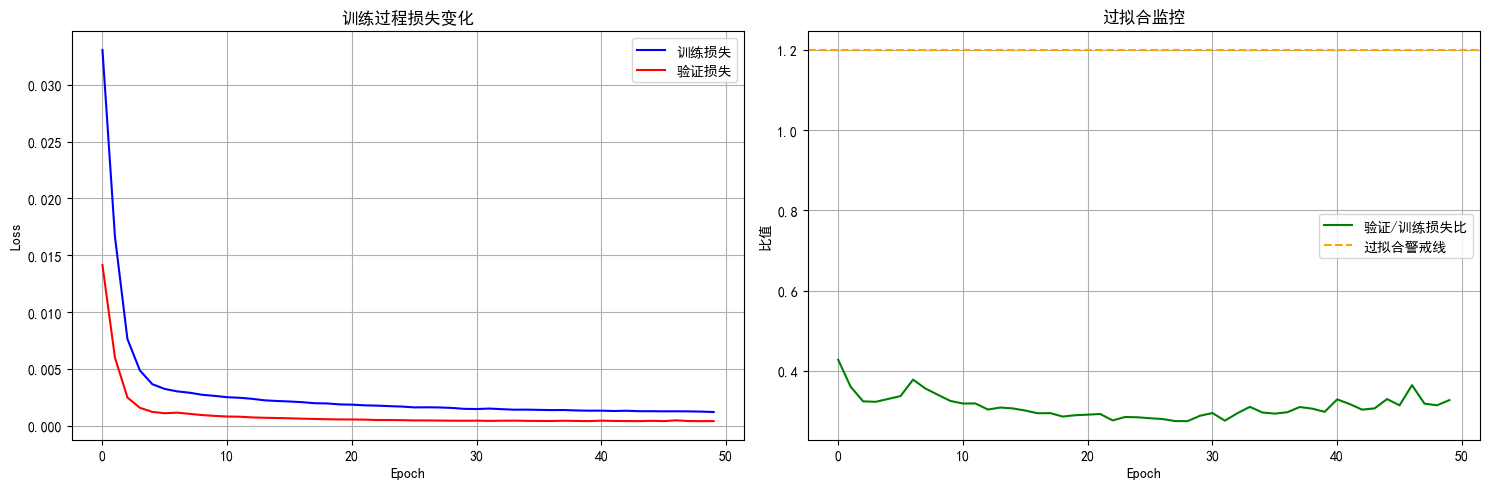


=== 训练总结 ===
最终训练损失: 0.001191
最终验证损失: 0.000389
最佳验证损失: 0.000384
过拟合程度: 0.33 (正常)
模型已保存为: best_model.pth


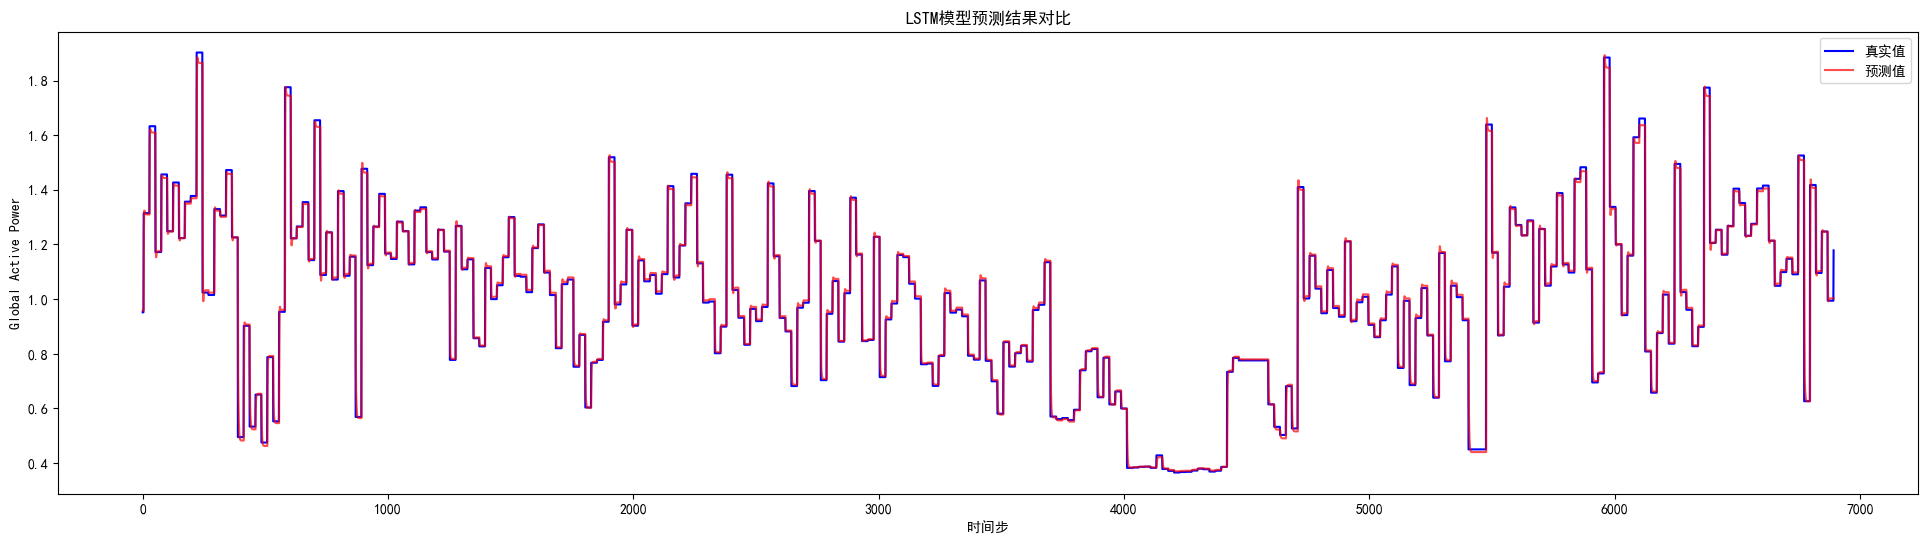

验证集 MSE: 0.000378, MAE: 0.005252, MAPE: 0.022175, R2: 0.961704


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, ParameterGrid, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
# 设置中文字体，用于图表显示
plt.rcParams['font.sans-serif'] = ['SimHei']
# 设置正常显示负号
plt.rcParams['axes.unicode_minus'] = True

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)     
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

# 优化的LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM层，添加dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        # 多层全连接网络
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()       # 激活函数层，增加网络的非线性表达能力，使模型能够拟合更复杂的数据关系。

    def forward(self, x):
        x = x.unsqueeze(-1)    # (batch, seq_len, 1)
        # LSTM前向传播
        out, _ = self.lstm(x)
        out = out[:, -1, :]    # 取最后一个时间步
        # 多层全连接 + dropout
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
# 创建模型
model = LSTMModel(input_size=1, hidden_size=128, num_layers=3, dropout=0.2).to(device)
# 计算模型参数量
total_params = sum(p.numel() for p in model.parameters())
print(f"模型参数量: {total_params:,}")
# 优化器添加权重衰减
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()
# 学习率调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# 训练循环
num_epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
patience = 5
for epoch in range(num_epochs):
    # ============ 训练阶段 ============
    model.train()
    train_loss = 0
    train_batches = 0
    
    # 训练进度条
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', 
                      ncols=100, leave=False)
    for x, y in train_pbar:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad()
        y_pred = model(x).squeeze()
        loss = loss_fn(y_pred, y)
        loss.backward()
        # 梯度裁剪防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
        train_batches += 1
        
        # 更新进度条显示当前loss
        train_pbar.set_postfix({'Loss': f'{loss.item():.6f}'})
    
    avg_train_loss = train_loss / train_batches
    
    # ============ 验证阶段 ============
    model.eval()
    val_loss = 0
    val_batches = 0
    
    # 验证进度条
    val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', 
                    ncols=100, leave=False)
    with torch.no_grad():
        for x, y in val_pbar:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model(x).squeeze()
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            val_batches += 1
            
            # 更新验证进度条
            val_pbar.set_postfix({'Loss': f'{loss.item():.6f}'})
    
    avg_val_loss = val_loss / val_batches
    # 学习率调度
    scheduler.step(avg_val_loss)
    # 记录损失
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    # 早停检查
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # 保存最佳模型
        torch.save(model.state_dict(), 'best_model.pth')
        best_epoch = epoch + 1
    else:
        patience_counter += 1
    
    # 显示epoch结果
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | LR: {current_lr:.6f}')
    
    # 早停
    if patience_counter >= patience:
        print(f"早停于epoch {epoch+1}，最佳模型在epoch {best_epoch}")
        break

print(f"\n训练完成！")
print(f"最佳验证损失: {best_val_loss:.6f} (epoch {best_epoch})")

# 加载最佳模型
model.load_state_dict(torch.load('best_model.pth'))

# 可视化训练过程
plt.figure(figsize=(15, 5))
# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='训练损失', color='blue')
plt.plot(val_losses, label='验证损失', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('训练过程损失变化')
plt.legend()
plt.grid(True)
# 过拟合分析
plt.subplot(1, 2, 2)
overfitting_ratio = [v/t if t > 0 else 1 for t, v in zip(train_losses, val_losses)]
plt.plot(overfitting_ratio, label='验证/训练损失比', color='green')
plt.axhline(y=1.2, color='orange', linestyle='--', label='过拟合警戒线')
plt.xlabel('Epoch')
plt.ylabel('比值')
plt.title('过拟合监控')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 性能总结
print("\n=== 训练总结 ===")
print(f"最终训练损失: {train_losses[-1]:.6f}")
print(f"最终验证损失: {val_losses[-1]:.6f}")
print(f"最佳验证损失: {best_val_loss:.6f}")
print(f"过拟合程度: {val_losses[-1]/train_losses[-1]:.2f} ({'正常' if val_losses[-1]/train_losses[-1] < 1.5 else '可能过拟合'})")
print(f"模型已保存为: best_model.pth")



# 在验证集上评估
model.eval()  # 评估模式
val_preds = []
val_targets = []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y_pred = model(x).squeeze().cpu().numpy()  # 预测值
        val_preds.extend(y_pred)
        val_targets.extend(y.numpy())
# 计算评估指标
val_preds = np.array(val_preds)
val_targets = np.array(val_targets)
mse = mean_squared_error(val_targets, val_preds)
mae = mean_absolute_error(val_targets, val_preds)
mape = mean_absolute_percentage_error(val_targets, val_preds) 
r2 = r2_score(val_targets, val_preds)

#反归一化
val_preds = scaler.inverse_transform(val_preds.reshape(-1, 1)).flatten()
val_targets = scaler.inverse_transform(val_targets.reshape(-1, 1)).flatten()

#画预测值与真实值对比图
plt.figure(figsize=(24, 6))
plt.plot(val_targets, label='真实值', color='blue')
plt.plot(val_preds, label='预测值', color='red', alpha=0.7)
plt.xlabel('时间步')
plt.ylabel('Global Active Power')
plt.title('LSTM模型预测结果对比')
plt.legend()
plt.show()
print(f'验证集 MSE: {mse:.6f}, MAE: {mae:.6f}, MAPE: {mape:.6f}, R2: {r2:.6f}')